## Document Classification.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv("shuffled-full-set-hashed.csv", header = None)
df.columns = ['Category', 'Content']
display(df.head())
print("Shape of data is : {}".format(df.shape))

,Category,Content
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...


Shape of data is : (62204, 2)


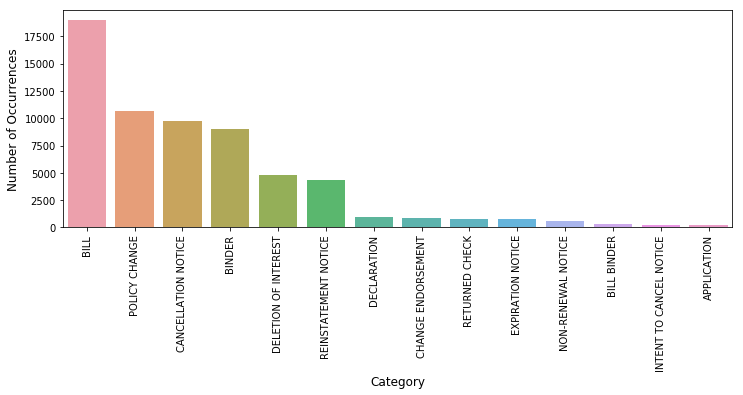

BILL                       18968
POLICY CHANGE              10627
CANCELLATION NOTICE         9731
BINDER                      8973
DELETION OF INTEREST        4826
REINSTATEMENT NOTICE        4368
DECLARATION                  968
CHANGE ENDORSEMENT           889
RETURNED CHECK               749
EXPIRATION NOTICE            734
NON-RENEWAL NOTICE           624
BILL BINDER                  289
INTENT TO CANCEL NOTICE      229
APPLICATION                  229
Name: Category, dtype: int64


In [3]:
cnt_categories = df['Category'].value_counts()

plt.figure(figsize=(12,4))
g = sns.barplot(cnt_categories.index, cnt_categories.values, alpha=0.9)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)

plt.show()
print(cnt_categories)

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# term frquency and document frequency vectorizer. Max_df and Min_df will filter out 
# terms that are very common(present in more than 70% of documents) or very rare(present in less than 1% documents)
# we will consider both 1 gram and 2 grams.
tfidf = TfidfVectorizer(sublinear_tf=True, max_df = 0.44, min_df = 0.01, norm='l2', ngram_range=(1, 2))

features = tfidf.fit_transform(df['Content'].values.astype('U')).toarray()
labels = df['Category']
features.shape

(62204, 3652)

In [5]:
N = 2
MAX = 4
i = 0
for Product, category_id in sorted(labels.items()):
    if i > MAX:
        break
    i = i + 1
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# '0':
  . Most correlated unigrams:
. 6b223a390d86
. d774c0d219f8
  . Most correlated bigrams:
. ba02159e05b1 892d541c89eb
. 6b223a390d86 6ce6cc5a3203
# '1':
  . Most correlated unigrams:
. 296e1c47e3cc
. 4bfcec3d7413
  . Most correlated bigrams:
. 75199e110c91 ff1c26ea0b6f
. eb562127f33e c0ed51271129
# '2':
  . Most correlated unigrams:
. d19b1c129f40
. 641356219cbc
  . Most correlated bigrams:
. f95d0bea231b 21e314d3afcc
. b9699ce57810 641356219cbc
# '3':
  . Most correlated unigrams:
. d19b1c129f40
. 641356219cbc
  . Most correlated bigrams:
. f95d0bea231b 21e314d3afcc
. b9699ce57810 641356219cbc
# '4':
  . Most correlated unigrams:
. d19b1c129f40
. 641356219cbc
  . Most correlated bigrams:
. f95d0bea231b 21e314d3afcc
. b9699ce57810 641356219cbc


In [6]:
models = [
    LinearSVC(),
    LogisticRegression(random_state=0),
]
CV = 5

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amandeep\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warn

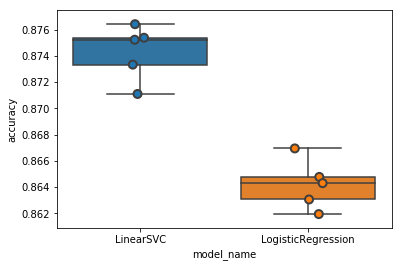

In [7]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [8]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, 
                                                                                 test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

In [9]:
print(accuracy_score(y_test, y_pred))

0.8716341130134233


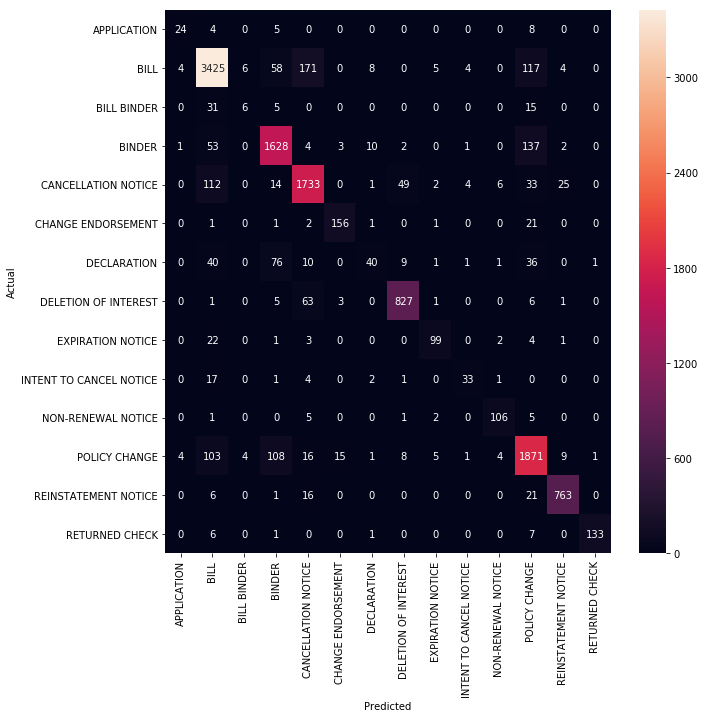

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
category_ids = df.groupby(['Category']).count().index
sns.heatmap(conf_mat, annot=True, fmt='d',
           xticklabels=category_ids, yticklabels=category_ids)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [17]:
category_id_df.groupby(['Category']).count()

,Content
Category,
APPLICATION,226
BILL,18449
BILL BINDER,277
BINDER,8590
CANCELLATION NOTICE,9571
CHANGE ENDORSEMENT,866
DECLARATION,966
DELETION OF INTEREST,4779
EXPIRATION NOTICE,719
